# Importing Librarires 

In [1]:
#Importing  Libraries and dependencies:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFE, chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve ,auc, precision_score,recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Exploratory Data Analysis:

In [2]:
# importing Dataset:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
# Displaying the first 5 rows:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# Getting the shape of data:
df.shape

(5110, 12)

In [5]:
# Descriptive Statistics:
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [6]:
# Getting the data types in columns:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
# Checking for the null values:
df.isnull().sum()/len(df)*100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [8]:
# Replacing the missing values:
mean_stroke = round(df[df.stroke == 1]['bmi'].mean())
mean_healthy = round(df[df.stroke == 0]['bmi'].mean())
mean_stroke,mean_healthy

(30, 29)

In [9]:
df['bmi'] = np.where((df.bmi.isnull()) & (df.stroke == 1), mean_stroke,df['bmi'])
df['bmi'] = np.where((df.bmi.isnull()) & (df.stroke == 0 ),mean_healthy,df['bmi'])

In [10]:
# Validating the changes:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
# Exploring the distribution of target variable among genders, in absolute and relative terms:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [12]:
# Exploring the categories in columns:
obj_col = df.select_dtypes(include='object')
obj_col.nunique()

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

In [13]:
# Removing instances :
obj_col[(obj_col.gender != 'Male') & (obj_col.gender != 'Female')]

,gender,ever_married,work_type,Residence_type,smoking_status
3116,Other,No,Private,Rural,formerly smoked


In [14]:
df.drop(df[(df.gender!='Male') & (df.gender != 'Female')].index,inplace=True)

In [15]:
# Exploring the shape of dataset for validation purposes:
df.shape

(5109, 12)

In [16]:
# Exploring the distribution or balance of target variable:
target_balance = df.stroke.value_counts()
target_balance = pd.DataFrame(target_balance)
print(f"The unbalanced state in terms of percentage, no-stroke: {round(target_balance['count'][0]/len(df),2)*100}%, stroke: {round(target_balance['count'][1]/len(df),2)*100}%")

The unbalanced state in terms of percentage, no-stroke: 95.0%, stroke: 5.0%


In [17]:
df.stroke.value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

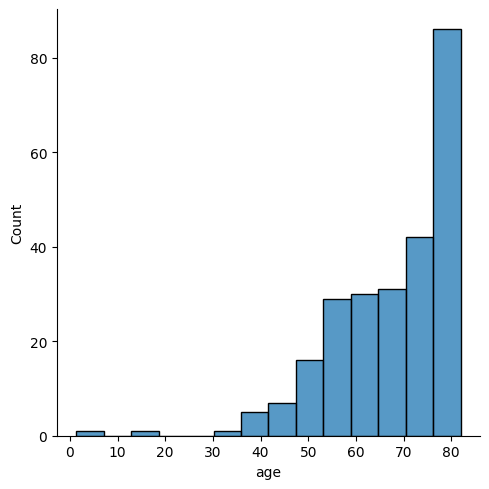

In [18]:
# Exploring more on the age featue and stroke incidence followed by what we revealed in descriptive statistics:
sns.displot(df[df.stroke == 1.0]['age'])
if not os.path.exists('pictures/Age_Stroke.png'):
    plt.savefig('pictures/Age_Stroke.png')
plt.show();

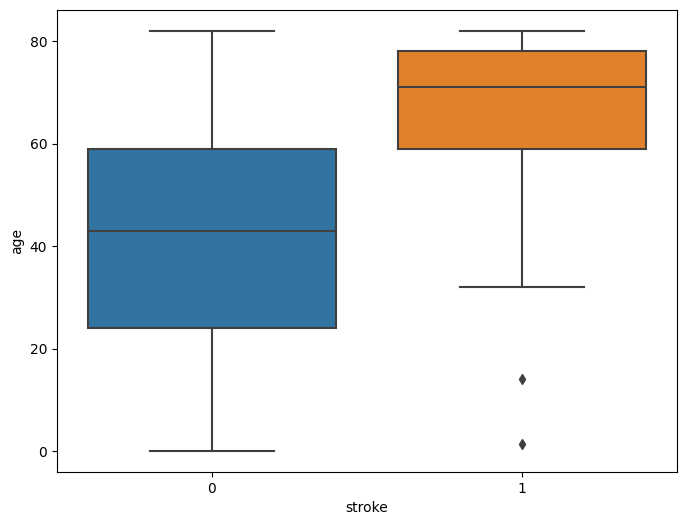

In [19]:
# Visualizing the any outliers in both stroke positive and negative instances based on age:
plt.figure(figsize=(8,6))
sns.boxplot(x='stroke',y='age',data=df)
if not os.path.exists('pictures/Box_plot.png'):
    plt.savefig('pictures/Box_plot.png')
plt.show();

In [20]:
# Removing the outliers detected above while exanding the policy since it will also
# decrease the imbalance between datasets:
q1 = df[df['stroke']==1]['age'].quantile(0.25)
q3 = df[df['stroke']==1]['age'].quantile(0.75)
iqr = q3-q1
lower_bound = q1 -1.5*iqr
upper_bound = q3 + 1.5*iqr
lower_bound,upper_bound
outliers = df[(df['age'] < lower_bound)]
df = df.drop(outliers.index,axis=0)


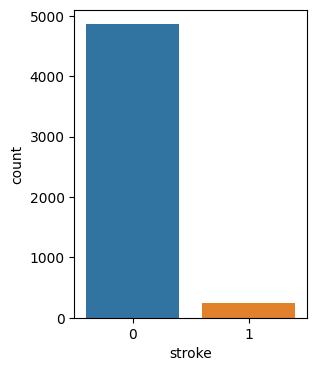

In [21]:
# Visualizing and validating the changes made in the preceeding step:
plt.figure(figsize=(3,4))
sns.barplot(data=target_balance,x=target_balance.index,y='count',)
if not os.path.exists('pictures/data_imbalance.png'):
    plt.savefig('pictures/data_imbalance.png')
plt.show();

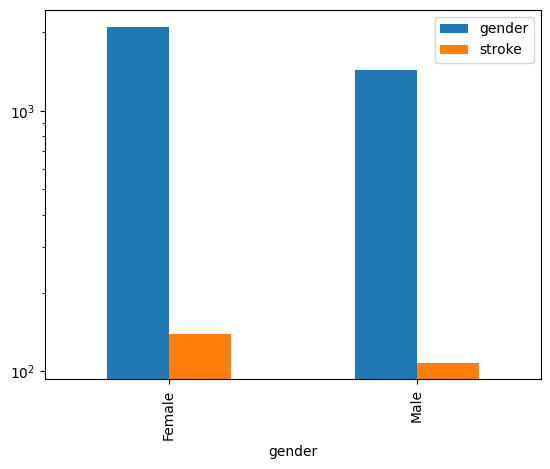

In [22]:
# Exapnding on, on our findings in the distribution of gender categories and visualizing it for better understanding:
gender_representation = df.groupby('gender').agg({'gender':'count','stroke':'sum'})
gender_representation.plot(kind='bar')
plt.yscale('log')
if not os.path.exists('pictures/gender_representation.png'):
    plt.savefig('pictures/gender_representation.png')
plt.show();

In [23]:
# Further visualizing the statistical distribution of numeric features, to visualize any peculiarity or anomaly:
numerical_data = (df.select_dtypes(exclude='object')).drop(columns = ['id','hypertension','heart_disease','stroke'])

In [24]:
numerical_data['stroke'] = df['stroke']

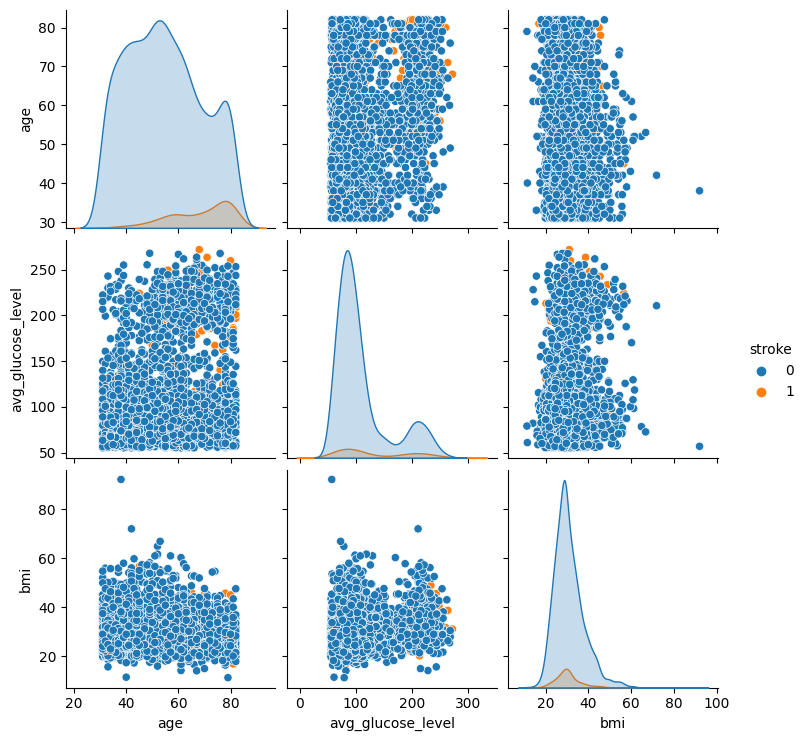

In [25]:
sns.pairplot(numerical_data,hue='stroke',)
if not os.path.exists('pictures/pair_plot.png'):
    plt.savefig('pictures/pair_plot.png')
plt.show();

# Data Preprocessing:

In [26]:
# Validating the current imbalance among target varioable:
target_balance = df.stroke.value_counts()
target_balance = pd.DataFrame(target_balance)
print(f"The unbalanced state in terms of percentage, no-stroke: {round(target_balance['count'][0]/len(df),2)*100}%, stroke: {round((target_balance['count'][1]/len(df)*100),2)}%")

The unbalanced state in terms of percentage, no-stroke: 93.0%, stroke: 6.98%


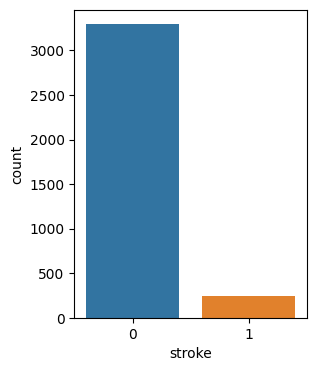

In [27]:
# Visualizing it :
plt.figure(figsize=(3,4))
sns.barplot(data=target_balance,x=target_balance.index,y='count',)
if not os.path.exists('pictures/data_imbalance_restore1.png'):
    plt.savefig('pictures/data_imbalance_restore_1.png')
plt.show();

## Encoding : 

In [28]:
# One Hot encoding the categorical data in this section:
to_encode = df.select_dtypes(include='object')
encode_columns = to_encode.columns.tolist()

In [29]:
# Following columns are to be encoded:
encode_columns

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [30]:
encoder_one_hot = OneHotEncoder(drop='first')
oh_encoded = encoder_one_hot.fit_transform(df[encode_columns])

In [31]:
# Validating the data to be encoded:
df[encode_columns]

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [32]:
# Validating processed encoding:
oh_encoded = pd.DataFrame(oh_encoded.toarray(),columns=encoder_one_hot.get_feature_names_out())
oh_encoded

,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
3535,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3536,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3537,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3538,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [33]:
# Dropping the redundat columns that add no value towards our goal:
df =df.drop(columns = encode_columns + ['id'])

In [34]:
# dropping the index:
df = df.reset_index(drop=True)

In [35]:
# Validating the changes:
df.tail()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
3535,80.0,1,0,83.75,29.0,0
3536,81.0,0,0,125.20,40.0,0
3537,35.0,0,0,82.99,30.6,0
3538,51.0,0,0,166.29,25.6,0
3539,44.0,0,0,85.28,26.2,0


In [36]:
# Concating the two sets of data:
df_encoded = pd.concat([df,oh_encoded],axis=1)
df_encoded.tail()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3535,80.0,1,0,83.75,29.0,0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3536,81.0,0,0,125.20,40.0,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3537,35.0,0,0,82.99,30.6,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3538,51.0,0,0,166.29,25.6,0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3539,44.0,0,0,85.28,26.2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
# Vlidating the null values and that the concatenation went as expected:
df_encoded.isna().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Male                       0
ever_married_Yes                  0
work_type_Private                 0
work_type_Self-employed           0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [38]:
# Validating the shape:
df_encoded.shape

(3540, 14)

## Scaling:

In [39]:
# seperating the dependent and independent variables:
# and scaling the independent features:
x,y = df_encoded.drop(columns='stroke'),df_encoded['stroke']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [40]:
len(X_scaled)

3540

## Training and Testing Sets:

In [41]:
# Splitting the data into training sets and testing data sets:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.35,stratify=y,random_state=10,shuffle=True)

In [42]:
# Validating the split:
y_train.value_counts() , y_test.value_counts()

(stroke
 0    2140
 1     161
 Name: count, dtype: int64,
 stroke
 0    1153
 1      86
 Name: count, dtype: int64)

## Resampling:

In [43]:
# Oversampling the minority classes using SMOTE:
smote = SMOTE(sampling_strategy={0: y_train.value_counts()[0],1:500}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
yResampled_df=pd.DataFrame(y_resampled.value_counts())

In [44]:
# Validating the changes made:
X_resampled.shape,y_resampled.shape

((2640, 13), (2640,))

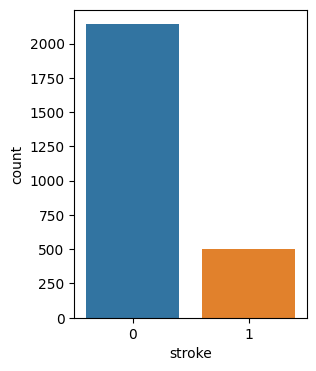

In [45]:
# Visualizing the changes:
plt.figure(figsize=(3,4))
sns.barplot(data=yResampled_df,x=yResampled_df.index,y='count')
if not os.path.exists('pictures/data_smote.png'):
    plt.savefig('pictures/data_smote.png')
plt.show();

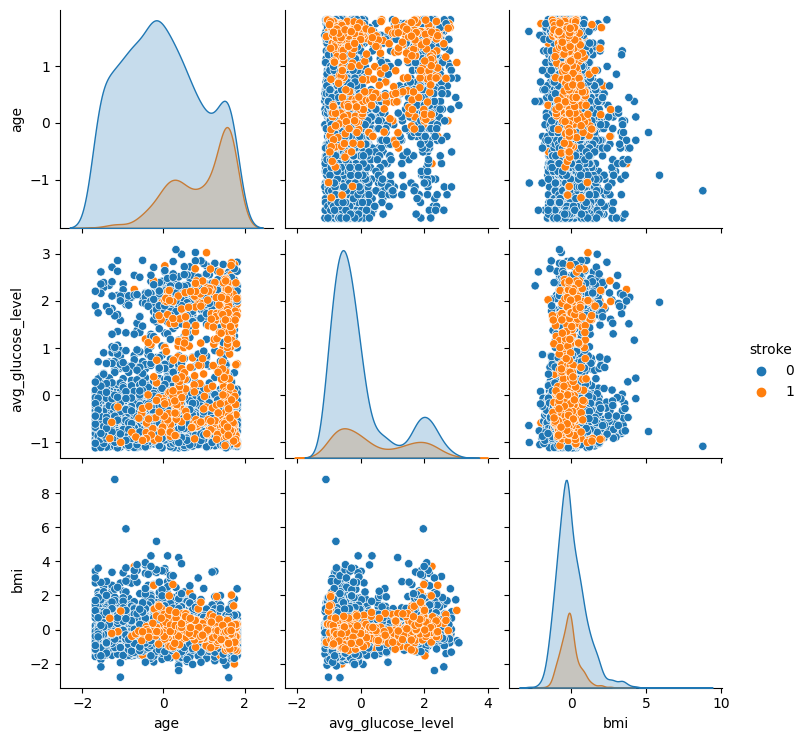

In [46]:
# Visualizing the effects of data preprocessing on statistical distributions :
num = pd.DataFrame(X_resampled[:,[0,3,4]])
num['stroke'] = y_resampled
num.columns = ['age','avg_glucose_level','bmi','stroke']
sns.pairplot(num,hue='stroke',)
plt.show();

# Model Selection:

In [47]:
# Importing the odels required:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Without GridSearchCV

In [48]:
# Trainng our models on training dataset with default hyper-parameters:
estimators_nogs = [
    ('random_forest', RandomForestClassifier()),
    ('svm', SVC()),
    ('logistic_regression', LogisticRegression()),
    ('Decision_tree',DecisionTreeClassifier()),
    ('SGD', SGDClassifier())
]

param_grids_nogs = {
    'random_forest': {
    },
    'svm': {
    },
    'logistic_regression': {
    },
    'Decision_tree': {
    },
    'SGD': {
    }
}
best_models_nogs = {}
for name, estimator in estimators_nogs:
    grid_search = GridSearchCV(estimator,param_grids_nogs[name],scoring =['accuracy','precision','recall'],refit='precision',cv=3,n_jobs=-1)
    grid_search.fit(X_resampled,y_resampled)
    best_models_nogs[name] = [grid_search.best_estimator_,grid_search.best_score_]


In [49]:
# Exploring the models and their corresponding accuracy:
best_models_nogs

{'random_forest': [RandomForestClassifier(), 0.8640165779336018],
 'svm': [SVC(), 0.7470489950366112],
 'logistic_regression': [LogisticRegression(), 0.4980599847064488],
 'Decision_tree': [DecisionTreeClassifier(), 0.5037983154494058],
 'SGD': [SGDClassifier(), 0.3642782270140761]}

### With GridSearchCV

In [50]:
# Contructing a grid space of hyper-parameters for our models:
estimators_gs = [
    ('random_forest', RandomForestClassifier()),
    ('svm', SVC()),
    ('logistic_regression', LogisticRegression()),
    ('Decision_tree',DecisionTreeClassifier()),
    ('SGD', SGDClassifier())
     
]

# Defining a parameter grid space for each estimator:
param_grids_gs = {
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'logistic_regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    'Decision_tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'SGD': {
        'loss': ['hinge', 'log', 'perceptron'],
        'penalty': ['l1', 'l2', 'elasticnet']
    }
}


In [51]:
# training and evualuating our models:
best_models_gs = {}
model = []
for name, estimator in estimators_gs:
    grid_search = GridSearchCV(estimator,param_grids_gs[name],scoring =['accuracy','precision','recall'],refit='precision',cv=3,n_jobs=-1)
    grid_search.fit(X_resampled,y_resampled)
    best_models_gs[name] = [grid_search.best_estimator_,grid_search.best_score_,grid_search.best_params_]

In [52]:
# The best model performance and their relative performance:
best_models_gs

{'random_forest': [RandomForestClassifier(max_depth=20),
  0.8671249543187768,
  {'max_depth': 20, 'n_estimators': 100}],
 'svm': [SVC(C=0.1), 0.8796296296296297, {'C': 0.1, 'kernel': 'rbf'}],
 'logistic_regression': [LogisticRegression(C=1),
  0.4980599847064488,
  {'C': 1, 'penalty': 'l2'}],
 'Decision_tree': [DecisionTreeClassifier(max_depth=10),
  0.5306513409961685,
  {'max_depth': 10, 'min_samples_split': 2}],
 'SGD': [SGDClassifier(penalty='l1'),
  0.30463458110516933,
  {'loss': 'hinge', 'penalty': 'l1'}]}

### Feature Selection

In [53]:
# Selecting the number of most important features to choose from a process of feature selection that yields the importance of corresponding features:
num_feats = 7
feature_name = list(x.columns)
embedded_rf_support = SelectFromModel(RandomForestClassifier(n_estimators=100),max_features = num_feats).fit(MinMaxScaler().fit_transform(X_train), y_train).get_support()
embedded_lr_support = SelectFromModel(LogisticRegression(penalty='l1',solver = 'liblinear',max_iter = 100),max_features = num_feats).fit(MinMaxScaler().fit_transform(X_train), y_train).get_support()
chi_support = SelectKBest(chi2, k = num_feats).fit(MinMaxScaler().fit_transform(X_train), y_train).get_support() 
rfe_support = RFE(estimator=LogisticRegression(),n_features_to_select=num_feats,step=10,).fit(MinMaxScaler().fit_transform(X_train),y_train).get_support()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embedded_lr_support,'Random Forest':embedded_rf_support})
feature_selection_df['Total'] = np.sum(feature_selection_df == True, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
best_features = feature_selection_df.Feature[:num_feats].to_list()
# Following are the features chosen for this purpose:
best_features

['avg_glucose_level',
 'age',
 'hypertension',
 'heart_disease',
 'Residence_type_Urban',
 'work_type_Self-employed',
 'smoking_status_smokes']

In [54]:
X_fs = x[best_features]

In [55]:
X_fs.shape

(3540, 7)

In [56]:
# A function that performs all the steps on the dataset that are required before it can be used by the model for training:
def processed_data(X_fs,y):
    df = pd.concat([X_fs,y],axis =1)
#     Encoding:
    to_encode = df.select_dtypes(include='object')
    encode_columns = to_encode.columns
    encoder_one_hot = OneHotEncoder(sparse=False,drop='first')
    oh_encoded = encoder_one_hot.fit_transform(df[encode_columns])
    oh_encoded = pd.DataFrame(oh_encoded,columns = encoder_one_hot.get_feature_names_out(input_features=encode_columns))
    df = df.drop(columns=encode_columns)
    df_encoded = pd.concat([df,oh_encoded],axis=1,join='inner')
    x,y = df_encoded.drop(columns='stroke'),df_encoded['stroke']
     # scaling
    scaler = StandardScaler()
    x_scaled = scaler.fit(x)
    X_scaled = scaler.transform(x)
    X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.35,stratify=y,random_state=10,shuffle=True)
    smote = SMOTE(sampling_strategy={0: y_train.value_counts()[0],1:500}, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    y_resampled.value_counts()
    if not os.path.exists('scaler.pkl'):
        joblib.dump(scaler,'scaler.pkl')
    if not os.path.exists('encoder.pkl'):
        joblib.dump(encoder_one_hot,'encoder.pkl')
  
    return X_resampled,y_resampled,X_test,y_test

In [57]:
# Utilizing the aforementioned function
X_train_fs,y_train_fs,X_test_fs,y_test_fs = processed_data(X_fs,y)

In [58]:
# Vlidating the task performed :
X_train_fs.shape,y_train_fs.shape,X_test_fs.shape

((2640, 7), (2640,), (1239, 7))

In [59]:
#  Making a grid space for hyper parameters again for the models that will be trained on the selected features alone:
estimators_fs = [
    ('random_forest', RandomForestClassifier()),
    ('svm', SVC()),
    ('logistic_regression', LogisticRegression()),
    ('Decision_tree',DecisionTreeClassifier()),
    ('SGD', SGDClassifier())
     
]

# Define a parameter grid for each estimator
param_grids_fs = {
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'logistic_regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    'Decision_tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'SGD': {
        'loss': ['hinge', 'log', 'perceptron'],
        'penalty': ['l1', 'l2', 'elasticnet']
    }
}


In [60]:
# Training the models:
best_models_fs = {}
for name, estimator in estimators_fs:
    grid_search = GridSearchCV(estimator,param_grids_fs[name],scoring ='accuracy',cv=3,n_jobs=-1)
    grid_search.fit(X_train_fs,y_train_fs)
    best_models_fs[name] = [grid_search.best_estimator_,grid_search.best_score_,grid_search.best_params_]


In [61]:
# Following are the results with their best performing combination of hyperparameters:
best_models_fs

{'random_forest': [RandomForestClassifier(n_estimators=200),
  0.8776515151515151,
  {'max_depth': None, 'n_estimators': 200}],
 'svm': [SVC(C=10), 0.8409090909090909, {'C': 10, 'kernel': 'rbf'}],
 'logistic_regression': [LogisticRegression(C=10),
  0.8159090909090909,
  {'C': 10, 'penalty': 'l2'}],
 'Decision_tree': [DecisionTreeClassifier(max_depth=10, min_samples_split=10),
  0.8314393939393939,
  {'max_depth': 10, 'min_samples_split': 10}],
 'SGD': [SGDClassifier(loss='perceptron', penalty='elasticnet'),
  0.8041666666666667,
  {'loss': 'perceptron', 'penalty': 'elasticnet'}]}

# Compare

In [62]:
# Here we compare the performances of all models based on the aforementioned strategies:
performance_gs = pd.DataFrame(best_models_gs).T.rename(columns={0:'estimator_GS',1:'acc_GS',2:'best_params_GS'})
performance_fs = pd.DataFrame(best_models_fs).T.rename(columns = {0:'estimator_FS',1:'acc_FS',2:'best_params_FS'})
performance_nogs = pd.DataFrame(best_models_nogs).T.rename(columns = {0:'estimator_noGS',1:'acc_noGS'})
performance_all = pd.concat([performance_nogs,performance_gs,performance_fs],axis = 1).reindex(columns = ['estimator_GS','best_params_GS','estimator_FS','best_params_FS','acc_noGS','acc_GS','acc_FS'])
performance_all



,estimator_GS,best_params_GS,estimator_FS,best_params_FS,acc_noGS,acc_GS,acc_FS
random_forest,"(DecisionTreeClassifier(max_depth=20, max_feat...","{'max_depth': 20, 'n_estimators': 100}","(DecisionTreeClassifier(max_features='sqrt', r...","{'max_depth': None, 'n_estimators': 200}",0.864017,0.867125,0.877652
svm,SVC(C=0.1),"{'C': 0.1, 'kernel': 'rbf'}",SVC(C=10),"{'C': 10, 'kernel': 'rbf'}",0.747049,0.87963,0.840909
logistic_regression,LogisticRegression(C=1),"{'C': 1, 'penalty': 'l2'}",LogisticRegression(C=10),"{'C': 10, 'penalty': 'l2'}",0.49806,0.49806,0.815909
Decision_tree,DecisionTreeClassifier(max_depth=10),"{'max_depth': 10, 'min_samples_split': 2}","DecisionTreeClassifier(max_depth=10, min_sampl...","{'max_depth': 10, 'min_samples_split': 10}",0.503798,0.530651,0.831439
SGD,SGDClassifier(penalty='l1'),"{'loss': 'hinge', 'penalty': 'l1'}","SGDClassifier(loss='perceptron', penalty='elas...","{'loss': 'perceptron', 'penalty': 'elasticnet'}",0.364278,0.304635,0.804167


In [63]:
# Combination of the best performing parameters:
performance_all.best_params_GS

random_forest             {'max_depth': 20, 'n_estimators': 100}
svm                                  {'C': 0.1, 'kernel': 'rbf'}
logistic_regression                    {'C': 1, 'penalty': 'l2'}
Decision_tree          {'max_depth': 10, 'min_samples_split': 2}
SGD                           {'loss': 'hinge', 'penalty': 'l1'}
Name: best_params_GS, dtype: object

In [64]:
# Comparison of accuracy:
performance_all.iloc[:,-3:].rename(columns = {'acc_noGS': 'Accuracy without GridSearch','acc_GS':'Accuracy with Best Model using GridSearch','acc_FS':'Accuracy with GridSearch and BestFeatures'})

,Accuracy without GridSearch,Accuracy with Best Model using GridSearch,Accuracy with GridSearch and BestFeatures
random_forest,0.864017,0.867125,0.877652
svm,0.747049,0.87963,0.840909
logistic_regression,0.49806,0.49806,0.815909
Decision_tree,0.503798,0.530651,0.831439
SGD,0.364278,0.304635,0.804167


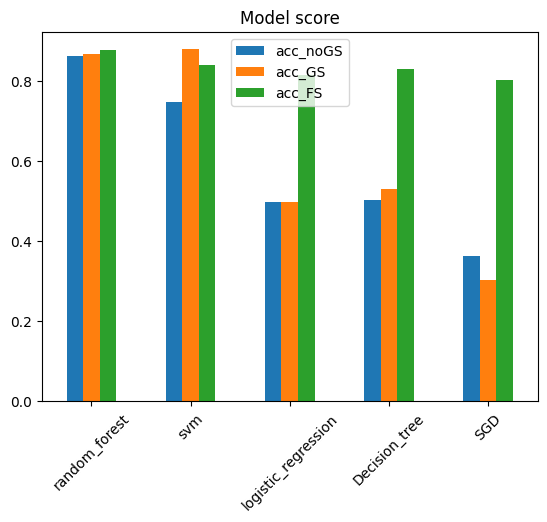

In [65]:
# Visualizing the comparison of accuracy:
performance_all[['acc_noGS','acc_GS','acc_FS']].plot(kind = 'bar').set(title = 'Model score')
plt.xticks(rotation= 45)
if not os.path.exists('pictures/acc_comparison.png'):
    plt.savefig('pictures/acc_comparison.png')
plt.show();

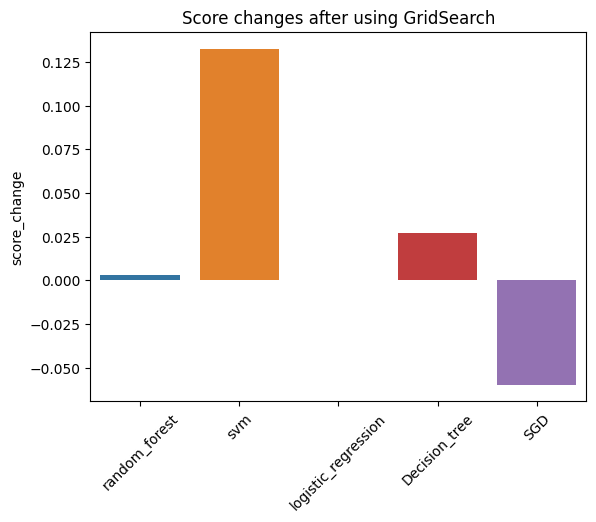

In [66]:
# Visualizing the affect of grid search on accuracy:
score_diff = pd.DataFrame(performance_all.acc_GS-performance_all.acc_noGS)
score_diff = score_diff.rename(columns={0:'score_change'})
sns.barplot(data=score_diff, x = score_diff.index,y = score_diff.score_change).set(title = 'Score changes after using GridSearch')
plt.xticks(rotation= 45)
if not os.path.exists('pictures/gridScore_Change.png'):
    plt.savefig('pictures/gridScore_Change.png')
plt.show();

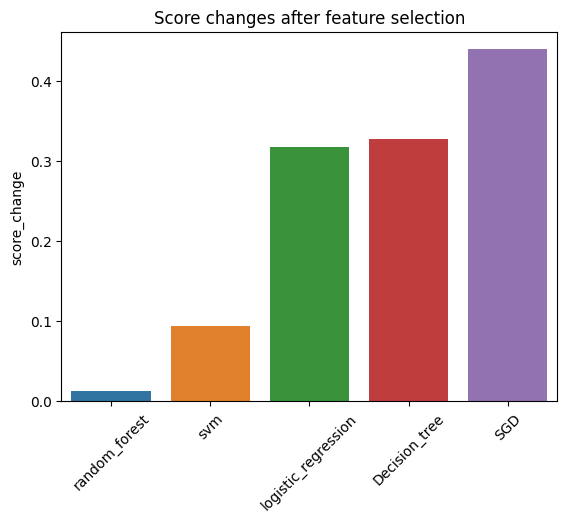

In [67]:
# Visualizing the effect of Feature Selection on accuracy:
score_diff = pd.DataFrame(performance_all.acc_FS-performance_all.acc_noGS)
score_diff = score_diff.rename(columns={0:'score_change'})
sns.barplot(data=score_diff, x = score_diff.index,y = score_diff.score_change).set(title = 'Score changes after feature selection')
plt.xticks(rotation= 45)
if not os.path.exists('pictures/featureSlct_ScoreChange.png'):
    plt.savefig('pictures/featureSlct_ScoreChange.png')
plt.show();

In [68]:
# Evaluatiing the models bnased on their predictions and using 'presion' and 'recall' for this purpose:
prec_recall_nogs, prec_recall_gs,prec_recall_fs = {},{},{}

for i in performance_nogs.estimator_noGS:
    model = i
    y_hat = model.predict(X_test)
    prec_recall_nogs[model] = {'Precision': precision_score(y_test,y_hat),'Recall': recall_score(y_test,y_hat)}

for i in performance_gs.estimator_GS:
    model = i
    y_hat = model.predict(X_test)
    prec_recall_gs[model] = {'Precision': precision_score(y_test,y_hat),'Recall': recall_score(y_test,y_hat)}

for i in performance_fs.estimator_FS:
    model = i
    y_hat = model.predict(X_test_fs)
    prec_recall_fs[model] = {'Precision': precision_score(y_test_fs,y_hat),'Recall': recall_score(y_test_fs,y_hat)}


In [69]:
# Assembling the results:
prec_recall_nogs = [{'Model':model,'Precision_nogs':scores['Precision'],'Recall_nogs':scores['Recall']} for model, scores in prec_recall_nogs.items()]
prec_recall_gs = [{'Model':model,'Precision_gs':scores['Precision'],'Recall_gs':scores['Recall']} for model, scores in prec_recall_gs.items()]
prec_recall_fs = [{'Model':model,'Precision_fs':scores['Precision'],'Recall_fs':scores['Recall']} for model, scores in prec_recall_fs.items()]

In [70]:
model = ['RandomForest','SVC','LogisticRegression','DecisionTree','SGD']
precRecall_nogs = pd.DataFrame(prec_recall_nogs).drop(columns='Model')
precRecall_nogs.index = model

precRecall_gs = pd.DataFrame(prec_recall_gs).drop(columns='Model')
precRecall_gs.index = model

precRecall_fs = pd.DataFrame(prec_recall_fs).drop(columns='Model')
precRecall_fs.index = model
# prec_recall_nogs

In [71]:
precRecall_all = pd.concat([precRecall_nogs,precRecall_gs,precRecall_fs],axis = 1)
prec_all = precRecall_all[['Precision_nogs','Precision_gs','Precision_fs']]
recall_all = precRecall_all[['Recall_nogs','Recall_gs','Recall_fs']]

# .reindex(columns = ['estimator_GS','best_params_GS','estimator_FS','best_params_FS','score_noGS','score_GS','score_FS'])
precRecall_all.reindex(columns = ['Precision_nogs','Precision_gs','Precision_fs','Recall_nogs','Recall_gs','Recall_fs'])

,Precision_nogs,Precision_gs,Precision_fs,Recall_nogs,Recall_gs,Recall_fs
RandomForest,0.166667,0.222222,0.148649,0.034884,0.046512,0.127907
SVC,0.117647,0.600000,0.127273,0.046512,0.034884,0.081395
LogisticRegression,0.214286,0.214286,0.220339,0.174419,0.174419,0.151163
DecisionTree,0.141791,0.170000,0.180556,0.220930,0.197674,0.151163
SGD,0.263158,0.167630,0.138408,0.058140,0.337209,0.465116


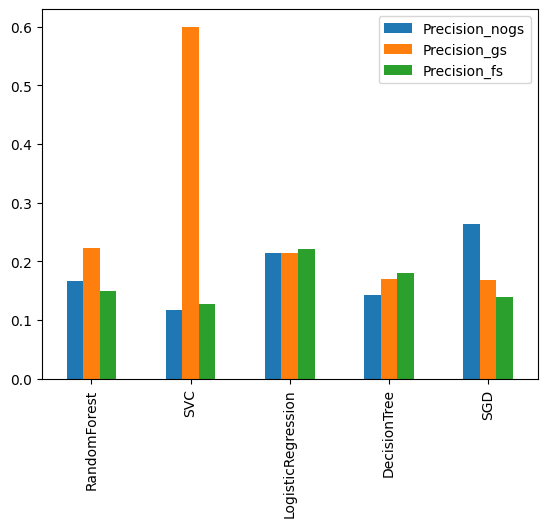

In [72]:
# Visualizing the Precision we got under different strategies for different models:
prec_all.plot(kind='bar')
if not os.path.exists('pictures/threeStrategy_precision.png'):
    plt.savefig('pictures/threeStrategy_precision.png')
plt.show();

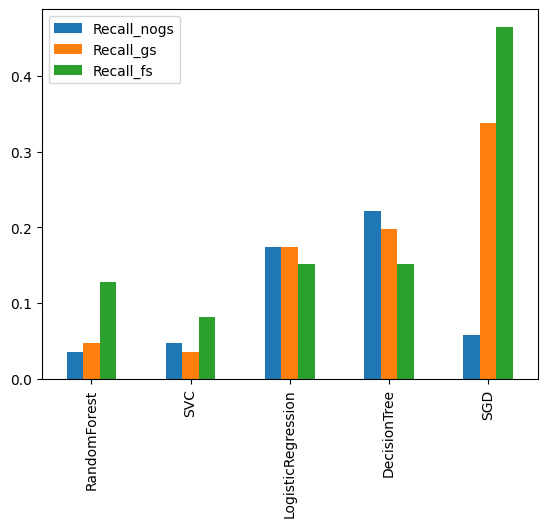

In [73]:
# Visualizing the Recall we got under different strategies for different models:
recall_all.plot(kind='bar')
if not os.path.exists('pictures/threeStrategy_recall.png'):
    plt.savefig('pictures/threeStrategy_recall.png')
plt.show();

# XGBoost

In [74]:
# instantiating the model:
boost_clf = XGBClassifier()

In [75]:
# training the model:
boost_clf.fit(X_resampled,y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [76]:
# Making predictions:
pred = boost_clf.predict(X_test)

In [77]:
# Getting the accracy:
accuracy_score(y_test,pred)

0.9168684422921711

In [78]:
# Getting the probabilities for ROC curve:
y_prob = boost_clf.predict_proba(X_test)[:,1]

In [79]:
fpr,tpr,thresholds = roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)

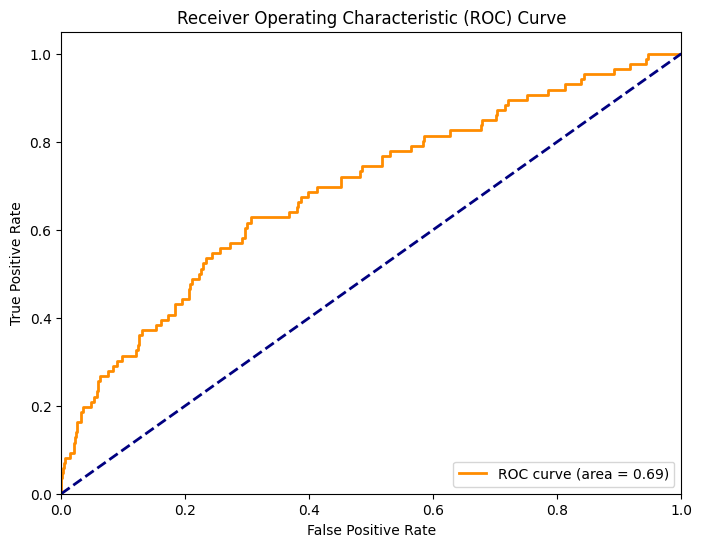

In [80]:
# PLotting the ROC curve:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [81]:
# Saving the model:
joblib.dump(boost_clf,'xgb_model.pkl')

['xgb_model.pkl']